In [188]:
# imports 
import pandas as pd 
import numpy as np
from collections import Counter
from pandas_profiling import ProfileReport
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.utils import all_estimators
from sklearn.metrics import accuracy_score, precision_score
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

# Task in hand 
1.Build a model that finds the fit % and detects the influence factor also makesure the fit% does not get biased by influence
factor


There are many ways to attack the task in hand:
1. Treat the calc fit% indep. and finding influence factor indep.
2. Build a model that calc fit%, find the the infulence factor using explainableAi methods


Let's start with the first approach. 
1. Treat the calc fit% indep. and finding influence factor indep.

1.a

Fit % calc is a regression problem - we should remove the bias factor col as a feature as we should not bias the regresssor.,

BiasFactor finding can be considred a classification problem.


In [223]:
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")
train_df.head()



EmpID  EmpName LanguageOfCommunication  Age  Gender  \
0  11041     John                 English   35    Male   
1  15079  William                 English   26    Male   
2  18638    James                 English   36  Female   
3   3941  Charles                 English   29  Female   
4   5936   George                 English   25    Male   

  JobProfileIDApplyingFor HighestDegree             DegreeBranch  \
0                 JR85289        B.Tech               Electrical   
1                 JR87525        B.Tech  Artificial Intelligence   
2                 JR87525           PhD         Computer Science   
3                 JR87525           BCA   Information Technology   
4                 JR70175   Dual M.Tech         Computer Science   

  GraduatingInstitute  LatestDegreeCGPA  ...  CurrentCTC  ExpectedCTC  \
0              Tier 1                 7  ...          21           26   
1              Tier 3                 7  ...          15           19   
2              Tier 1                 6  ...          15           24   
3              Tier 2                 5  ...          16           24   
4              Tier 3                 8  ...          24           32   

   MartialStatus  EmpScore CurrentDesignation  CurrentCompanyType  \
0        Married         5                SSE          Enterprise   
1        Married         5                 BA            MidSized   
2         Single         5                SDE            MidSized   
3        Married         5                SDE             Startup   
4        Married         5                SDE          Enterprise   

  DepartmentInCompany TotalLeavesTaken BiasInfluentialFactor  FitmentPercent  
0              Design               20      YearsOfExperince           95.40  
1         Engineering                6                   NaN           67.09  
2         Engineering               19                Gender           91.26  
3             Product               16                Gender           72.29  
4         Engineering               10          DegreeBranch           86.34  

[5 rows x 22 columns]

In [4]:
# pandas profilling 
profile = ProfileReport(train_df,)
profile

Summarize dataset:   0%|          | 0/35 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
profile.to_file("Data_profilling.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# EDA - comments 



1. BIasinfluencefactor has missing values:


1.a  What does it mean for the "BiasInfluentialFactor" to be null? Does that mean there is no bias in Fitment Percent or more than one column influencing the bias in Fitment Percent.


1.b BiasInfluentialFactor column having 328 values of Ethinicity. But ethinicity is not a feature present in the dataset, Can we equivate it to the Language ?




In [13]:
train_df.describe()

EmpID           Age  LatestDegreeCGPA  YearsOfExperince  \
count  13645.000000  13645.000000      13645.000000      13645.000000   
mean   13150.781239     30.691242          7.100257          6.547746   
std     6475.019626      3.881378          1.346539          3.426920   
min     2001.000000     24.000000          4.000000          1.000000   
25%     7501.000000     28.000000          6.000000          4.000000   
50%    13173.000000     31.000000          7.000000          7.000000   
75%    18718.000000     34.000000          8.000000          9.000000   
max    24390.000000     42.000000         10.000000         12.000000   

       GraduationYear    CurrentCTC   ExpectedCTC      EmpScore  \
count    13645.000000  13645.000000  13645.000000  13645.000000   
mean      2014.452254     18.076951     25.061488      3.392085   
std          3.426920      7.208130      7.478119      1.044676   
min       2009.000000      6.000000     10.000000      1.000000   
25%       2012.000000     12.000000     19.000000      3.000000   
50%       2014.000000     18.000000     25.000000      3.000000   
75%       2017.000000     24.000000     31.000000      4.000000   
max       2020.000000     30.000000     40.000000      5.000000   

       TotalLeavesTaken  FitmentPercent  
count      13645.000000    13645.000000  
mean          11.967021       75.880093  
std            4.897836       14.894207  
min            4.000000       33.530000  
25%            8.000000       68.720000  
50%           12.000000       78.110000  
75%           16.000000       87.990000  
max           20.000000       95.500000

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13645 entries, 0 to 13644
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmpID                    13645 non-null  int64  
 1   EmpName                  13645 non-null  object 
 2   LanguageOfCommunication  13645 non-null  object 
 3   Age                      13645 non-null  int64  
 4   Gender                   13645 non-null  object 
 5   JobProfileIDApplyingFor  13645 non-null  object 
 6   HighestDegree            13645 non-null  object 
 7   DegreeBranch             13645 non-null  object 
 8   GraduatingInstitute      13645 non-null  object 
 9   LatestDegreeCGPA         13645 non-null  int64  
 10  YearsOfExperince         13645 non-null  int64  
 11  GraduationYear           13645 non-null  int64  
 12  CurrentCTC               13645 non-null  int64  
 13  ExpectedCTC              13645 non-null  int64  
 14  MartialStatus         

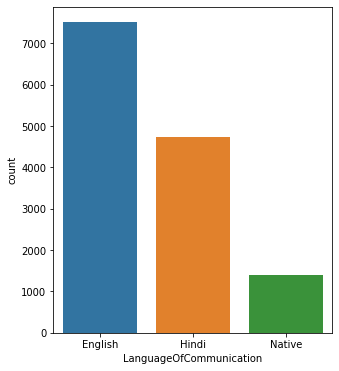

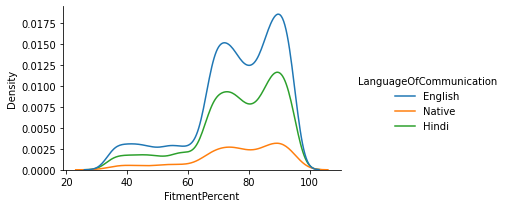

In [32]:
fig, ax =plt.subplots(1, figsize = (5,6))
sns.countplot(x="LanguageOfCommunication", data=train_df, order=["English", "Hindi", "Native"], ax = ax)
sns.displot(train_df, x="FitmentPercent", hue="LanguageOfCommunication", kind = "kde", height=3, aspect=10/6)

* english has the highest count with 55 % applicant being english
* Density plots show that htere are no bias from Language

In [41]:
train_df.columns

Index(['EmpID', 'EmpName', 'LanguageOfCommunication', 'Age', 'Gender',
       'JobProfileIDApplyingFor', 'HighestDegree', 'DegreeBranch',
       'GraduatingInstitute', 'LatestDegreeCGPA', 'YearsOfExperince',
       'GraduationYear', 'CurrentCTC', 'ExpectedCTC', 'MartialStatus',
       'EmpScore', 'CurrentDesignation', 'CurrentCompanyType',
       'DepartmentInCompany', 'TotalLeavesTaken', 'BiasInfluentialFactor',
       'FitmentPercent'],
      dtype='object')

In [58]:
Req_col = ['LanguageOfCommunication','Gender',
       'JobProfileIDApplyingFor', 'HighestDegree', 'DegreeBranch',
       'GraduatingInstitute', 'LatestDegreeCGPA', 'YearsOfExperince',
       'GraduationYear',  'MartialStatus',
       'EmpScore', 'CurrentDesignation', 'CurrentCompanyType']

for i in Req_col:
    print(pd.DataFrame({ str(i): train_df[i].value_counts().index, 'Count':train_df[i].value_counts().values, 'Count%': train_df[i].value_counts(normalize=True).values.round(2)}))


  LanguageOfCommunication  Count  Count%
0                 English   7510    0.55
1                   Hindi   4733    0.35
2                  Native   1402    0.10
   Gender  Count  Count%
0    Male   8376    0.61
1  Female   4326    0.32
2   Other    943    0.07
  JobProfileIDApplyingFor  Count  Count%
0                 JR85289   4697    0.34
1                 JR87525   3416    0.25
2                 JR88879   1231    0.09
3                 JR89890   1157    0.08
4                 JR88873   1123    0.08
5                 JR81165    681    0.05
6                 JR79193    678    0.05
7                 JR88654    420    0.03
8                 JR70175    242    0.02
  HighestDegree  Count  Count%
0        B.Tech   5619    0.41
1        M.Tech   2026    0.15
2           BCA   1634    0.12
3            MS   1579    0.12
4   Dual M.Tech   1358    0.10
5      Dual MBA    665    0.05
6           PhD    624    0.05
7           MCA    140    0.01
                 DegreeBranch  Count  Count%
0 

In [59]:
# English appicants are almost 55%
# Male Applicants are 61%
# JR85289 has highest applicants 
# most apllicants are B.tech 
# 34% of the applicants have counputer sci degree
# 45% of them are from tier 2 colleges 
# most of them have CGPA of 7
# 72% of the applicants are married
# 47% of app are from startups 

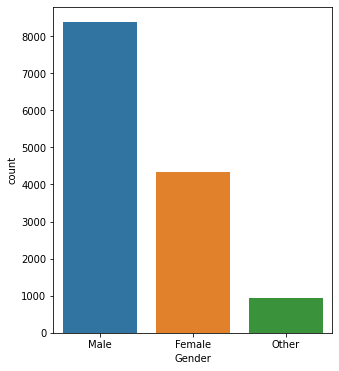

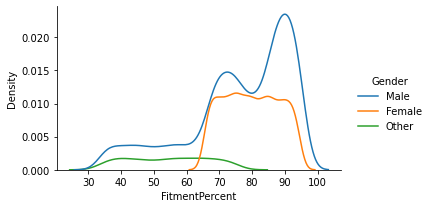

In [60]:
# Lets see if there is some BIas towards Gender 
fig, ax =plt.subplots(1, figsize = (5,6))
sns.countplot(x="Gender", data=train_df, order=["Male", "Female", "Other"], ax = ax)
sns.displot(train_df, x="FitmentPercent", hue="Gender", kind = "kde", height=3, aspect=10/6)

** Female candidate are usually have higher fit% than male and others. their min score is 60
** Other gender candidates are not having high fit%

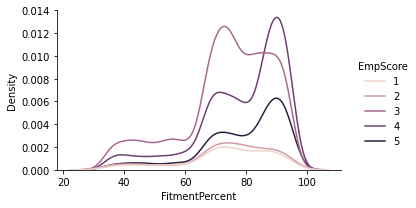

In [65]:

# Lets see if there is some BIas towards Empscore

# fig, ax =plt.subplots(1, figsize = (5,6))
# emp_count = train_df.EmpScore.value_counts(normalize=True)
# sns.countplot(x="EmpScore", data=train_df, order=emp_count, ax = ax)
sns.displot(train_df, x="FitmentPercent", hue="EmpScore", kind = "kde", height=3, aspect=10/6)

* we cannot say anything conclusive from the empscore dist plot 

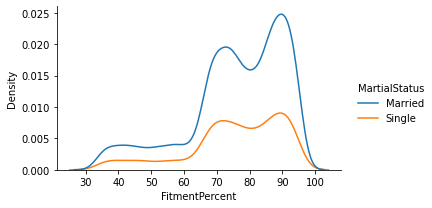

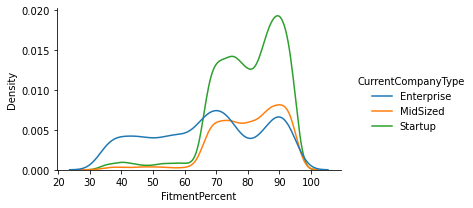

In [74]:
sns.displot(train_df, x="FitmentPercent", hue="MartialStatus", kind = "kde", height=3, aspect=10/6)
sns.displot(train_df, x="FitmentPercent", hue="CurrentCompanyType", kind = "kde", height=3, aspect=10/6)

* Enterprise candidates have almost uniform dist in fit %
* Starttup Candidates usuallu have high fit%

In [224]:
# dropping unwanted columns Id,Name
train_df_fit = train_df.drop(columns=["EmpID", "EmpName","BiasInfluentialFactor"])
test_df_fit = test_df.drop(columns=["EmpID", "EmpName"])

In [225]:
train_df_fit.head()

LanguageOfCommunication  Age  Gender JobProfileIDApplyingFor HighestDegree  \
0                 English   35    Male                 JR85289        B.Tech   
1                 English   26    Male                 JR87525        B.Tech   
2                 English   36  Female                 JR87525           PhD   
3                 English   29  Female                 JR87525           BCA   
4                 English   25    Male                 JR70175   Dual M.Tech   

              DegreeBranch GraduatingInstitute  LatestDegreeCGPA  \
0               Electrical              Tier 1                 7   
1  Artificial Intelligence              Tier 3                 7   
2         Computer Science              Tier 1                 6   
3   Information Technology              Tier 2                 5   
4         Computer Science              Tier 3                 8   

   YearsOfExperince  GraduationYear  CurrentCTC  ExpectedCTC MartialStatus  \
0                12            2009          21           26       Married   
1                 3            2018          15           19       Married   
2                 6            2015          15           24        Single   
3                 6            2015          16           24       Married   
4                 2            2019          24           32       Married   

   EmpScore CurrentDesignation CurrentCompanyType DepartmentInCompany  \
0         5                SSE         Enterprise              Design   
1         5                 BA           MidSized         Engineering   
2         5                SDE           MidSized         Engineering   
3         5                SDE            Startup             Product   
4         5                SDE         Enterprise         Engineering   

   TotalLeavesTaken  FitmentPercent  
0                20           95.40  
1                 6           67.09  
2                19           91.26  
3                16           72.29  
4                10           86.34

In [226]:
# Let's encode our categorical  cols in our data
# Let's use one hot encoding to avoid converting the categorical features into ordinal feautres. 
# We avoid that because the ordering might  Bias the regressor 

In [227]:
def one_hot(df,col_name):
    temp_df = pd.get_dummies(df[col_name],col_name) 
    
    df = pd.concat([df,temp_df],axis=1)
    df=df.drop(columns=[col_name])
    return df

In [228]:
# one hot because no heirarchy should be learnt
train_df_fit= one_hot(train_df_fit,"Gender") 
train_df_fit = one_hot(train_df_fit,"LanguageOfCommunication")
train_df_fit = one_hot(train_df_fit,"MartialStatus")

In [229]:
# one hot because no heirarchy should be learnt
test_df_fit= one_hot(test_df_fit,"Gender") 
test_df_fit = one_hot(test_df_fit,"LanguageOfCommunication")
test_df_fit = one_hot(test_df_fit,"MartialStatus")

In [230]:
train_df_fit

Age JobProfileIDApplyingFor HighestDegree             DegreeBranch  \
0       35                 JR85289        B.Tech               Electrical   
1       26                 JR87525        B.Tech  Artificial Intelligence   
2       36                 JR87525           PhD         Computer Science   
3       29                 JR87525           BCA   Information Technology   
4       25                 JR70175   Dual M.Tech         Computer Science   
...    ...                     ...           ...                      ...   
13640   25                 JR87525      Dual MBA               Electrical   
13641   29                 JR87525   Dual M.Tech         Computer Science   
13642   37                 JR88873        M.Tech  Artificial Intelligence   
13643   24                 JR87525        B.Tech               Electrical   
13644   35                 JR87525        B.Tech               Electrical   

      GraduatingInstitute  LatestDegreeCGPA  YearsOfExperince  GraduationYear  \
0                  Tier 1                 7                12            2009   
1                  Tier 3                 7                 3            2018   
2                  Tier 1                 6                 6            2015   
3                  Tier 2                 5                 6            2015   
4                  Tier 3                 8                 2            2019   
...                   ...               ...               ...             ...   
13640              Tier 2                 7                 2            2019   
13641              Tier 1                 7                 6            2015   
13642              Tier 1                 8                11            2010   
13643              Tier 2                 4                 1            2020   
13644              Tier 2                 7                12            2009   

       CurrentCTC  ExpectedCTC  ...  TotalLeavesTaken FitmentPercent  \
0              21           26  ...                20          95.40   
1              15           19  ...                 6          67.09   
2              15           24  ...                19          91.26   
3              16           24  ...                16          72.29   
4              24           32  ...                10          86.34   
...           ...          ...  ...               ...            ...   
13640          30           34  ...                 5          93.65   
13641          22           28  ...                14          52.90   
13642           8           16  ...                20          61.46   
13643          27           36  ...                 7          93.64   
13644          17           24  ...                16          93.52   

      Gender_Female Gender_Male  Gender_Other  \
0                 0           1             0   
1                 0           1             0   
2                 1           0             0   
3                 1           0             0   
4                 0           1             0   
...             ...         ...           ...   
13640             1           0             0   
13641             0           0             1   
13642             0           1             0   
13643             0           1             0   
13644             0           1             0   

       LanguageOfCommunication_English  LanguageOfCommunication_Hindi  \
0                                    1                              0   
1                                    1                              0   
2                                    1                              0   
3                                    1                              0   
4                                    1                              0   
...                                ...                            ...   
13640                                1                              0   
13641                                0                              0  

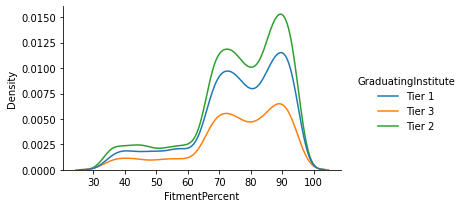

In [231]:
# Lets work on GraduatingInstitute 
sns.displot(train_df, x="FitmentPercent", hue="GraduatingInstitute", kind = "kde", height=3, aspect=10/6)


In [232]:
# there is no bias based on institute 
# Encoding Graduaction institute
train_df_fit["GraduatingInstitute"] = train_df_fit["GraduatingInstitute"].map(lambda x: int(x.split(" ")[1]))

In [233]:
test_df_fit["GraduatingInstitute"] = test_df_fit["GraduatingInstitute"].map(lambda x: int(x.split(" ")[1]))

In [234]:
# Lets encode degree  coloumn 
train_df_fit["DegreeBranch"] = train_df_fit["DegreeBranch"].map({'Electrical': 0,'Artificial Intelligence': 1,
         'Computer Science': 2,'Information Technology': 3,'Electronics': 4,'Electrical and Electronics': 5})
test_df_fit["DegreeBranch"] = test_df_fit["DegreeBranch"].map({'Electrical': 0,'Artificial Intelligence': 1,
         'Computer Science': 2,'Information Technology': 3,'Electronics': 4,'Electrical and Electronics': 5})

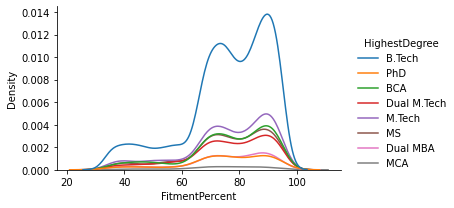

In [235]:
# encoding Highestdegree
sns.displot(train_df, x="FitmentPercent", hue="HighestDegree", kind = "kde", height=3, aspect=10/6)


In [236]:
# there seems to be no bias in fit% in reagrds to degree 
# Lets encode them ordinally 
train_df_fit["HighestDegree"] = train_df_fit["HighestDegree"].map({'BCA':0,"B.Tech":1, "MCA":2,"M.Tech":3,"MS":4 , "Dual M.Tech":5,"Dual MBA":6 , "PhD":7})
test_df_fit["HighestDegree"] = test_df_fit["HighestDegree"].map({'BCA':0,"B.Tech":1, "MCA":2,"M.Tech":3,"MS":4 , "Dual M.Tech":5,"Dual MBA":6 , "PhD":7})

In [237]:
train_df_fit.head()

Age JobProfileIDApplyingFor  HighestDegree  DegreeBranch  \
0   35                 JR85289              1             0   
1   26                 JR87525              1             1   
2   36                 JR87525              7             2   
3   29                 JR87525              0             3   
4   25                 JR70175              5             2   

   GraduatingInstitute  LatestDegreeCGPA  YearsOfExperince  GraduationYear  \
0                    1                 7                12            2009   
1                    3                 7                 3            2018   
2                    1                 6                 6            2015   
3                    2                 5                 6            2015   
4                    3                 8                 2            2019   

   CurrentCTC  ExpectedCTC  ...  TotalLeavesTaken FitmentPercent  \
0          21           26  ...                20          95.40   
1          15           19  ...                 6          67.09   
2          15           24  ...                19          91.26   
3          16           24  ...                16          72.29   
4          24           32  ...                10          86.34   

  Gender_Female Gender_Male  Gender_Other  LanguageOfCommunication_English  \
0             0           1             0                                1   
1             0           1             0                                1   
2             1           0             0                                1   
3             1           0             0                                1   
4             0           1             0                                1   

   LanguageOfCommunication_Hindi  LanguageOfCommunication_Native  \
0                              0                               0   
1                              0                               0   
2                              0                               0   
3                              0                               0   
4                              0                               0   

   MartialStatus_Married  MartialStatus_Single  
0                      1                     0  
1                      1                     0  
2                      0                     1  
3                      1                     0  
4                      1                     0  

[5 rows x 24 columns]

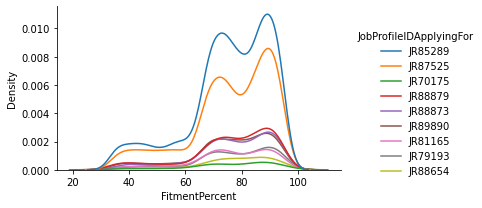

In [238]:
# Let's encode Job Id
sns.displot(train_df, x="FitmentPercent", hue="JobProfileIDApplyingFor", kind = "kde", height=3, aspect=10/6)

In [239]:
train_df_fit["JobProfileIDApplyingFor"] = train_df_fit["JobProfileIDApplyingFor"].map({'JR85289': 0,'JR87525': 1,
         'JR70175': 2,'JR88879': 3,'JR88873': 4,'JR89890': 5,'JR81165': 6,'JR79193': 7,'JR88654': 8})

test_df_fit["JobProfileIDApplyingFor"] = test_df_fit["JobProfileIDApplyingFor"].map({'JR85289': 0,         'JR87525': 1,
         'JR70175': 2,'JR88879': 3,'JR88873': 4,'JR89890': 5,'JR81165': 6,'JR79193': 7,'JR88654': 8})

In [240]:
train_df_fit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13645 entries, 0 to 13644
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              13645 non-null  int64  
 1   JobProfileIDApplyingFor          13645 non-null  int64  
 2   HighestDegree                    13645 non-null  int64  
 3   DegreeBranch                     13645 non-null  int64  
 4   GraduatingInstitute              13645 non-null  int64  
 5   LatestDegreeCGPA                 13645 non-null  int64  
 6   YearsOfExperince                 13645 non-null  int64  
 7   GraduationYear                   13645 non-null  int64  
 8   CurrentCTC                       13645 non-null  int64  
 9   ExpectedCTC                      13645 non-null  int64  
 10  EmpScore                         13645 non-null  int64  
 11  CurrentDesignation               13645 non-null  object 
 12  CurrentCompanyType

In [241]:
# Encding companytype 
train_df_fit= one_hot(train_df_fit,"CurrentCompanyType") 
test_df_fit= one_hot(test_df_fit,"CurrentCompanyType") 

In [242]:
# Encding companydesignatio
train_df_fit= one_hot(train_df_fit,"CurrentDesignation") 
test_df_fit= one_hot(test_df_fit,"CurrentDesignation") 

In [243]:
# Encding companydepartment
train_df_fit= one_hot(train_df_fit,"DepartmentInCompany") 
test_df_fit= one_hot(test_df_fit,"DepartmentInCompany") 

In [244]:
train_df_fit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13645 entries, 0 to 13644
Data columns (total 37 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   13645 non-null  int64  
 1   JobProfileIDApplyingFor               13645 non-null  int64  
 2   HighestDegree                         13645 non-null  int64  
 3   DegreeBranch                          13645 non-null  int64  
 4   GraduatingInstitute                   13645 non-null  int64  
 5   LatestDegreeCGPA                      13645 non-null  int64  
 6   YearsOfExperince                      13645 non-null  int64  
 7   GraduationYear                        13645 non-null  int64  
 8   CurrentCTC                            13645 non-null  int64  
 9   ExpectedCTC                           13645 non-null  int64  
 10  EmpScore                              13645 non-null  int64  
 11  TotalLeavesTake

In [245]:
# Now we have our Data converted 
# Now let's set a base line 
x_train , x_test , y_train , y_test = train_test_split(train_df_fit.drop(columns=["FitmentPercent"]), train_df_fit["FitmentPercent"] , test_size = 0.20,random_state=1)
print(x_train.shape)

(10916, 36)


In [246]:
skl_regression = LinearRegression()

skl_regression.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [247]:
print("Train performance ")
print("MAE:",mean_absolute_error(y_train,skl_regression.predict(x_train)))
print("MSE:",mean_squared_error(y_train,skl_regression.predict(x_train)))
print("R2:",r2_score(y_train,skl_regression.predict(x_train)))

print("Test performance ")
print("MAE:",mean_absolute_error(y_test,skl_regression.predict(x_test)))
print("MSE:",mean_squared_error(y_test,skl_regression.predict(x_test)))
print("R2:",r2_score(y_test,skl_regression.predict(x_test)))

Train performance 
MAE: 9.470657034399046
MSE: 139.37817840484476
R2: 0.3697371481821947
Test performance 
MAE: 9.692172728105534
MSE: 145.01637033590313
R2: 0.35334944627454357


In [248]:
scores = cross_val_score(skl_regression, x_train, y_train, scoring='r2', cv=5)
scores

array([0.38142117, 0.3744765 , 0.37749832, 0.34989586, 0.33552462])

So our base line score is found. 
Let's remove some unwanted coloms and feature engineering 

In [213]:
# Let's create a new feature called SalaryJumpExpected which ExpectedSalary-CurrentSalary. 
# The SalarayJumpExpected is an important factor  that determines fit% by HR individuals

train_df_fit["ExpectedSalaryJump"] = train_df_fit["ExpectedCTC"] - train_df_fit["CurrentCTC"] 
train_df_fit = train_df_fit.drop(columns=["ExpectedCTC","CurrentCTC"])
test_df_fit["ExpectedSalaryJump"] = test_df_fit["ExpectedCTC"] - test_df_fit["CurrentCTC"] 
test_df_fit = test_df_fit.drop(columns=["ExpectedCTC","CurrentCTC"])

^^ Not giving much improvement

In [249]:
# Let's drop Graduation year as it is highly corr with years of experience. 
train_df_fit = train_df_fit.drop(columns=["GraduationYear"])
test_df_fit = test_df_fit.drop(columns=["GraduationYear"])

In [251]:
# Now we have our Data converted 
# Now let's set a base line 
x_train , x_test , y_train , y_test = train_test_split(train_df_fit.drop(columns=["FitmentPercent"]), train_df_fit["FitmentPercent"] , test_size = 0.20,random_state=1)
print(x_train.shape)


skl_regression = LinearRegression()

skl_regression.fit(x_train, y_train)


print("Train performance ")
print("MAE:",mean_absolute_error(y_train,skl_regression.predict(x_train)))
print("MSE:",mean_squared_error(y_train,skl_regression.predict(x_train)))
print("R2:",r2_score(y_train,skl_regression.predict(x_train)))

print("Test performance ")
print("MAE:",mean_absolute_error(y_test,skl_regression.predict(x_test)))
print("MSE:",mean_squared_error(y_test,skl_regression.predict(x_test)))
print("R2:",r2_score(y_test,skl_regression.predict(x_test)))

(10916, 35)
Train performance 
MAE: 9.470032386430326
MSE: 139.3788594273963
R2: 0.3697340686239712
Test performance 
MAE: 9.691626967796697
MSE: 145.02101236947465
R2: 0.3533287467247447


In [250]:
train_df_fit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13645 entries, 0 to 13644
Data columns (total 36 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   13645 non-null  int64  
 1   JobProfileIDApplyingFor               13645 non-null  int64  
 2   HighestDegree                         13645 non-null  int64  
 3   DegreeBranch                          13645 non-null  int64  
 4   GraduatingInstitute                   13645 non-null  int64  
 5   LatestDegreeCGPA                      13645 non-null  int64  
 6   YearsOfExperince                      13645 non-null  int64  
 7   CurrentCTC                            13645 non-null  int64  
 8   ExpectedCTC                           13645 non-null  int64  
 9   EmpScore                              13645 non-null  int64  
 10  TotalLeavesTaken                      13645 non-null  int64  
 11  FitmentPercent 

In [222]:
scores = cross_val_score(skl_regression, x_train, y_train, scoring='r2', cv=5)
scores

array([0.35173062, 0.36122603, 0.35554794, 0.33257894, 0.32117597])

# Checking other regression methods 

In [257]:
# SVM 

reg =  SVR()
params = {"C":[1e-1,1e0,1e1],'degree':[2,3,5],'kernel':['linear','rbf']}

reg = GridSearchCV(reg,params,n_jobs=-1,scoring='r2')
reg.fit(x_train, y_train)



print("Train performance ")
print("MAE:",mean_absolute_error(y_train,reg.predict(x_train)))
print("MSE:",mean_squared_error(y_train,reg.predict(x_train)))
print("R2:",r2_score(y_train,reg.predict(x_train)))

print("Test performance ")
print("MAE:",mean_absolute_error(y_test,reg.predict(x_test)))
print("MSE:",mean_squared_error(y_test,reg.predict(x_test)))
print("R2:",r2_score(y_test,reg.predict(x_test)))

scores = cross_val_score(reg, x_train, y_train, scoring='r2', cv=5)
scores

Train performance 
MAE: 9.375264004641105
MSE: 142.15118214938693
R2: 0.3571977301173376
Test performance 
MAE: 9.65706342135907
MSE: 148.98031935256188
R2: 0.3356735809868904


array([0.37173468, 0.36325946, 0.36563512, 0.33931117, 0.31658809])

In [261]:
# lets try some tree based methods 

reg =  RandomForestRegressor()
params = {}#{"C":[1e-1,1e0,1e1],'degree':[2,3,5],'kernel':['linear','rbf']}

# reg = GridSearchCV(reg,params,n_jobs=-1,scoring='r2')
reg.fit(X= x_train, y= y_train)



print("Train performance ")
print("MAE:",mean_absolute_error(y_train,reg.predict(x_train)))
print("MSE:",mean_squared_error(y_train,reg.predict(x_train)))
print("R2:",r2_score(y_train,reg.predict(x_train)))

print("Test performance ")
print("MAE:",mean_absolute_error(y_test,reg.predict(x_test)))
print("MSE:",mean_squared_error(y_test,reg.predict(x_test)))
print("R2:",r2_score(y_test,reg.predict(x_test)))

scores = cross_val_score(reg, x_train, y_train, scoring='r2', cv=5)
scores

Train performance 
MAE: 2.7624816049835106
MSE: 11.673906065271165
R2: 0.9472110382503376
Test performance 
MAE: 7.5940252839868085
MSE: 85.13903124262366
R2: 0.6203518156662831


array([0.62641252, 0.62917595, 0.63251508, 0.61339243, 0.61361735])

In [263]:
# thats Great improvement. Lets see waht ahppens in boosted trees 


reg =GradientBoostingRegressor(random_state=10)
params = {}#{"C":[1e-1,1e0,1e1],'degree':[2,3,5],'kernel':['linear','rbf']}

# reg = GridSearchCV(reg,params,n_jobs=-1,scoring='r2')
reg.fit(X= x_train, y= y_train)



print("Train performance ")
print("MAE:",mean_absolute_error(y_train,reg.predict(x_train)))
print("MSE:",mean_squared_error(y_train,reg.predict(x_train)))
print("R2:",r2_score(y_train,reg.predict(x_train)))

print("Test performance ")
print("MAE:",mean_absolute_error(y_test,reg.predict(x_test)))
print("MSE:",mean_squared_error(y_test,reg.predict(x_test)))
print("R2:",r2_score(y_test,reg.predict(x_test)))

scores = cross_val_score(reg, x_train, y_train, scoring='r2', cv=5)
scores

Train performance 
MAE: 7.53628218520781
MSE: 82.69575348299794
R2: 0.626052930093361
Test performance 
MAE: 7.819417209214603
MSE: 87.63347140282943
R2: 0.6092287189628157


array([0.61915141, 0.61142868, 0.62048589, 0.59654733, 0.60200234])

In [264]:


reg =XGBRegressor()
params = {}#{"C":[1e-1,1e0,1e1],'degree':[2,3,5],'kernel':['linear','rbf']}

# reg = GridSearchCV(reg,params,n_jobs=-1,scoring='r2')
reg.fit(X= x_train, y= y_train)



print("Train performance ")
print("MAE:",mean_absolute_error(y_train,reg.predict(x_train)))
print("MSE:",mean_squared_error(y_train,reg.predict(x_train)))
print("R2:",r2_score(y_train,reg.predict(x_train)))

print("Test performance ")
print("MAE:",mean_absolute_error(y_test,reg.predict(x_test)))
print("MSE:",mean_squared_error(y_test,reg.predict(x_test)))
print("R2:",r2_score(y_test,reg.predict(x_test)))

scores = cross_val_score(reg, x_train, y_train, scoring='r2', cv=5)
scores

Train performance 
MAE: 4.516340097558066
MSE: 32.31699255745018
R2: 0.8538637818018338
Test performance 
MAE: 7.927769958619102
MSE: 93.1442265737382
R2: 0.5846554044159178


array([0.57661339, 0.5876454 , 0.58693828, 0.56518048, 0.56630343])

In [266]:
# So we have the highes performance from randomforest regressor. But we overfiiting on train data. 
# So lets Find the best parameters for the RF regressor
# lets try some tree based methods 

reg =  RandomForestRegressor(n_jobs=-1)
params = {'n_estimators':[50,100,150,200,350],}

reg = GridSearchCV(reg,params,n_jobs=-1,scoring='r2')
reg.fit(X= x_train, y= y_train)



print("Train performance ")
print("MAE:",mean_absolute_error(y_train,reg.predict(x_train)))
print("MSE:",mean_squared_error(y_train,reg.predict(x_train)))
print("R2:",r2_score(y_train,reg.predict(x_train)))

print("Test performance ")
print("MAE:",mean_absolute_error(y_test,reg.predict(x_test)))
print("MSE:",mean_squared_error(y_test,reg.predict(x_test)))
print("R2:",r2_score(y_test,reg.predict(x_test)))

scores = cross_val_score(reg, x_train, y_train, scoring='r2', cv=5)
scores


Train performance 
MAE: 2.7461383578495493
MSE: 11.308068451469158
R2: 0.9488653421049004
Test performance 
MAE: 7.584226477516619
MSE: 84.35211474560013
R2: 0.6238607987373479


array([0.62806398, 0.63134058, 0.63709884, 0.61715974, 0.61721716])

In [267]:
reg.best_params_


{'n_estimators': 350}

In [272]:
# lets try some tree based methods 

reg =  RandomForestRegressor(n_estimators=500,n_jobs=-1)
params = {}#{"C":[1e-1,1e0,1e1],'degree':[2,3,5],'kernel':['linear','rbf']}

# reg = GridSearchCV(reg,params,n_jobs=-1,scoring='r2')
reg.fit(X= x_train, y= y_train)



print("Train performance ")
print("MAE:",mean_absolute_error(y_train,reg.predict(x_train)))
print("MSE:",mean_squared_error(y_train,reg.predict(x_train)))
print("R2:",r2_score(y_train,reg.predict(x_train)))

print("Test performance ")
print("MAE:",mean_absolute_error(y_test,reg.predict(x_test)))
print("MSE:",mean_squared_error(y_test,reg.predict(x_test)))
print("R2:",r2_score(y_test,reg.predict(x_test)))

scores = cross_val_score(reg, x_train, y_train, scoring='r2', cv=5)
scores

Train performance 
MAE: 2.7422153684957866
MSE: 11.245926425443407
R2: 0.9491463459965351
Test performance 
MAE: 7.561811043422499
MSE: 84.06867040889425
R2: 0.6251247211266385


array([0.62900378, 0.63108967, 0.63516988, 0.61575007, 0.61987919])

In [279]:

print("max_depth :",max([estimator.get_depth() for estimator in reg.estimators_]))

max_depth : 42


In [284]:
#let's try to prune the trees 
reg =  RandomForestRegressor(n_estimators=500,n_jobs=-1)
params = {'max_depth':[2,3,4,5,15,25,35,45]}#{"C":[1e-1,1e0,1e1],'degree':[2,3,5],'kernel':['linear','rbf']}

reg = GridSearchCV(reg,params,n_jobs=-1,scoring='r2')
reg.fit(X= x_train, y= y_train)



print("Train performance ")
print("MAE:",mean_absolute_error(y_train,reg.predict(x_train)))
print("MSE:",mean_squared_error(y_train,reg.predict(x_train)))
print("R2:",r2_score(y_train,reg.predict(x_train)))

print("Test performance ")
print("MAE:",mean_absolute_error(y_test,reg.predict(x_test)))
print("MSE:",mean_squared_error(y_test,reg.predict(x_test)))
print("R2:",r2_score(y_test,reg.predict(x_test)))

# scores = cross_val_score(reg, x_train, y_train, scoring='r2', cv=5)
# scores

Train performance 
MAE: 7.237689097015774
MSE: 76.63877498899744
R2: 0.6534423577836799
Test performance 
MAE: 7.5046356454573715
MSE: 81.29002037817374
R2: 0.6375151538537348


In [285]:
reg.best_params_

{'max_depth': 5}

In [302]:
# Cool ...We have a generalised model now... which is not overfitting  
# Let's finalise this model, and fit it with the entire train  

reg =RandomForestRegressor(n_estimators=500,max_depth=5,n_jobs=-1)
reg.fit(X= train_df_fit.drop(columns=["FitmentPercent"]), y=train_df_fit["FitmentPercent"])


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [303]:
reg.score(X= train_df_fit.drop(columns=["FitmentPercent"]), y=train_df_fit["FitmentPercent"])

0.6505003634103879

In [298]:
# lets do an ensmeble using stacking 
from sklearn.ensemble import StackingRegressor
estimators = [
    ('lr', XGBRegressor(n_jobs=-1)),
    ('rfr', RandomForestRegressor(n_estimators=500,max_depth=5,n_jobs=-1)),
    ('et' , ExtraTreesRegressor())
]
model = StackingRegressor(estimators)

model.fit(X= x_train, y= y_train)



print("Train performance ")
print("MAE:",mean_absolute_error(y_train,model.predict(x_train)))
print("MSE:",mean_squared_error(y_train,model.predict(x_train)))
print("R2:",r2_score(y_train,model.predict(x_train)))

print("Test performance ")
print("MAE:",mean_absolute_error(y_test,model.predict(x_test)))
print("MSE:",mean_squared_error(y_test,model.predict(x_test)))
print("R2:",r2_score(y_test,model.predict(x_test)))


Train performance 
MAE: 7.578769907508543
MSE: 84.08142513149421
R2: 0.6197869753014451
Test performance 
MAE: 7.5009474360101835
MSE: 81.2015238983365
R2: 0.6379097734236283


In [299]:
model.fit(X= train_df_fit.drop(columns=["FitmentPercent"]), y=train_df_fit["FitmentPercent"])
model.score(X= train_df_fit.drop(columns=["FitmentPercent"]), y=train_df_fit["FitmentPercent"])

0.60423368832416

In [304]:
# the ensemble didnt help us so lets stick to the predictions of Randonforest regressors

Fit_prediction_test =  reg.predict(test_df_fit)

# Now lets deal with BIasinfluencefactor

1. BIasinfluencefactor has missing values:


1.a  What does it mean for the "BiasInfluentialFactor" to be null? Does that mean there is no bias in Fitment Percent or more than one column influencing the bias in Fitment Percent.


1.b BiasInfluentialFactor column having 328 values of Ethinicity. But ethinicity is not a feature present in the dataset, Can we equivate it to the Language ?



** Let's equivate ethinicity to languageofcommunication
** let's approach this as classification problem. 
    1. One where we build a model that emits "none"  meaning there is no bias in the fit%
  
  Also we can use fit% as a feature here. It can give the model insight regarding which feature influenced the fit%
  

In [423]:
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

In [424]:
# dropping unwanted columns Id,Name
train_df_bias = train_df.drop(columns=["EmpID", "EmpName"])
test_df_bias = test_df.drop(columns=["EmpID", "EmpName"])

# one hot because no heirarchy should be learnt
train_df_bias= one_hot(train_df_bias,"Gender") 
train_df_bias = one_hot(train_df_bias,"LanguageOfCommunication")
train_df_bias = one_hot(train_df_bias,"MartialStatus")

# one hot because no heirarchy should be learnt
test_df_bias= one_hot(test_df_bias,"Gender") 
test_df_bias = one_hot(test_df_bias,"LanguageOfCommunication")
test_df_bias = one_hot(test_df_bias,"MartialStatus")


# there seems to be no bias in bias% in reagrds to degree 
# Lets encode them ordinally 
train_df_bias["HighestDegree"] = train_df_bias["HighestDegree"].map({'BCA':0,"B.Tech":1, "MCA":2,"M.Tech":3,"MS":4 , "Dual M.Tech":5,"Dual MBA":6 , "PhD":7})
test_df_bias["HighestDegree"] = test_df_bias["HighestDegree"].map({'BCA':0,"B.Tech":1, "MCA":2,"M.Tech":3,"MS":4 , "Dual M.Tech":5,"Dual MBA":6 , "PhD":7})

train_df_bias["JobProfileIDApplyingFor"] = train_df_bias["JobProfileIDApplyingFor"].map({'JR85289': 0,'JR87525': 1,
         'JR70175': 2,'JR88879': 3,'JR88873': 4,'JR89890': 5,'JR81165': 6,'JR79193': 7,'JR88654': 8})

test_df_bias["JobProfileIDApplyingFor"] = test_df_bias["JobProfileIDApplyingFor"].map({'JR85289': 0,         'JR87525': 1,
         'JR70175': 2,'JR88879': 3,'JR88873': 4,'JR89890': 5,'JR81165': 6,'JR79193': 7,'JR88654': 8})


# there is no bias based on institute 
# Encoding Graduaction institute
train_df_bias["GraduatingInstitute"] = train_df_bias["GraduatingInstitute"].map(lambda x: int(x.split(" ")[1]))

test_df_bias["GraduatingInstitute"] = test_df_bias["GraduatingInstitute"].map(lambda x: int(x.split(" ")[1]))

# Lets encode degree  coloumn 
train_df_bias["DegreeBranch"] = train_df_bias["DegreeBranch"].map({'Electrical': 0,'Artificial Intelligence': 1,
         'Computer Science': 2,'Information Technology': 3,'Electronics': 4,'Electrical and Electronics': 5})
test_df_bias["DegreeBranch"] = test_df_bias["DegreeBranch"].map({'Electrical': 0,'Artificial Intelligence': 1,
         'Computer Science': 2,'Information Technology': 3,'Electronics': 4,'Electrical and Electronics': 5})


# Encding companytype 
train_df_bias= one_hot(train_df_bias,"CurrentCompanyType") 
test_df_bias= one_hot(test_df_bias,"CurrentCompanyType") 

# Encding companydesignatio
train_df_bias= one_hot(train_df_bias,"CurrentDesignation") 
test_df_bias= one_hot(test_df_bias,"CurrentDesignation") 

# Encding companydepartment
train_df_bias= one_hot(train_df_bias,"DepartmentInCompany") 
test_df_bias= one_hot(test_df_bias,"DepartmentInCompany") 

In [425]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [426]:
train_df_bias["BiasInfluentialFactor"] =  train_df_bias["BiasInfluentialFactor"].replace(np.nan,"None")
le.fit(y=train_df_bias["BiasInfluentialFactor"].astype(str))




LabelEncoder()

In [427]:
Counter(train_df_bias["BiasInfluentialFactor"] )

Counter({'YearsOfExperince': 1561,
         'None': 3336,
         'Gender': 2605,
         'DegreeBranch': 2858,
         'CurrentCompanyType': 1174,
         'MartialStatus': 280,
         'HighestDegree': 582,
         'EmpScore': 659,
         'Ethinicity': 328,
         'LatestDegreeCGPA': 262})

In [428]:
train_df_bias["BiasInfluentialFactor"] = le.transform(train_df_bias["BiasInfluentialFactor"])

In [429]:
train_df_bias = train_df_bias.drop(columns=["FitmentPercent"])

In [430]:
train_df_bias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13645 entries, 0 to 13644
Data columns (total 37 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   Age                                   13645 non-null  int64
 1   JobProfileIDApplyingFor               13645 non-null  int64
 2   HighestDegree                         13645 non-null  int64
 3   DegreeBranch                          13645 non-null  int64
 4   GraduatingInstitute                   13645 non-null  int64
 5   LatestDegreeCGPA                      13645 non-null  int64
 6   YearsOfExperince                      13645 non-null  int64
 7   GraduationYear                        13645 non-null  int64
 8   CurrentCTC                            13645 non-null  int64
 9   ExpectedCTC                           13645 non-null  int64
 10  EmpScore                              13645 non-null  int64
 11  TotalLeavesTaken                      136

In [431]:
x_train , x_test , y_train , y_test = train_test_split(train_df_bias.drop(columns=["BiasInfluentialFactor"]), train_df_bias["BiasInfluentialFactor"] , test_size = 0.20,random_state=1)


In [432]:

from sklearn.ensemble import GradientBoostingClassifier
model_bias = GradientBoostingClassifier(learning_rate= 0.05 , n_estimators= 101 )
model_bias.fit(x_train , y_train)

print(classification_report(y_test,model_bias.predict(x_test)))

              precision    recall  f1-score   support

           0       0.72      0.24      0.36       245
           1       0.89      0.94      0.91       573
           2       0.72      0.99      0.83       103
           3       0.00      0.00      0.00        62
           4       0.83      1.00      0.91       531
           5       0.85      0.96      0.90       111
           6       0.54      0.20      0.30        64
           7       0.55      0.87      0.67        47
           8       0.70      0.72      0.71       677
           9       0.87      0.96      0.91       316

    accuracy                           0.80      2729
   macro avg       0.67      0.69      0.65      2729
weighted avg       0.77      0.80      0.77      2729



/home/nitins/ICD-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


** As seen there is no ethinicity in dataset features. If it was equivated to Language then it would have had a nice f1 score.
Here we have only 3% f1 score for it. But Except Languange there is no other feature in the data that can be equivated to ethinicity. So Nothing can be done about it.


In [433]:
accuracy_score(y_test, model_bias.predict(x_test))

0.7980945401245878

WE have a good accuracy, also the performance of clasiffier accross classes seems good (except ethinicity ofcourse)

In [434]:
model_bias.fit(train_df_bias.drop(columns=["BiasInfluentialFactor"]), train_df_bias["BiasInfluentialFactor"])
model_bias.score(train_df_bias.drop(columns=["BiasInfluentialFactor"]), train_df_bias["BiasInfluentialFactor"])

0.8115793330890436

In [407]:
# test_df_bias["FitmentPercent"] = [np.round(x,decimals=2) for x in Fit_prediction_test]

In [436]:
Bias_prediction_test = model_bias.predict(test_df_bias)

In [437]:
le.inverse_transform(Bias_prediction_test)

array(['DegreeBranch', 'DegreeBranch', 'MartialStatus', ...,
       'DegreeBranch', 'None', 'LatestDegreeCGPA'], dtype=object)

In [438]:
Counter(model_bias.predict(x_test))

Counter({9: 350, 8: 689, 4: 638, 1: 597, 2: 142, 5: 124, 0: 90, 7: 75, 6: 24})

In [439]:
Counter((le.inverse_transform(Bias_prediction_test)))

Counter({'DegreeBranch': 1905,
         'MartialStatus': 279,
         'None': 2244,
         'Gender': 1916,
         'YearsOfExperince': 1088,
         'HighestDegree': 402,
         'LatestDegreeCGPA': 90,
         'CurrentCompanyType': 275,
         'EmpScore': 545,
         'Ethinicity': 1})

In [440]:
Bias_prediction_test = le.inverse_transform(Bias_prediction_test)

In [405]:
train_df_bias["FitmentPercent"]

0        95.40
1        67.09
2        91.26
3        72.29
4        86.34
         ...  
13640    93.65
13641    52.90
13642    61.46
13643    93.64
13644    93.52
Name: FitmentPercent, Length: 13645, dtype: float64

In [443]:
test_df  = pd.read_csv("Test.csv")

In [444]:
submssion_df = pd.DataFrame()
submssion_df["EmpID"] = test_df["EmpID"]
submssion_df["BiasInfluentialFactor"] = Bias_prediction_test
submssion_df["FitmentPercent"] =  [np.round(x,decimals=2) for x in Fit_prediction_test]

In [446]:
submssion_df["BiasInfluentialFactor"] = submssion_df["BiasInfluentialFactor"].replace("None","")

In [448]:
submssion_df.to_csv("Final_submission.csv")

In [449]:
submssion_df

EmpID BiasInfluentialFactor  FitmentPercent
0      5664          DegreeBranch           90.67
1     23568          DegreeBranch           90.67
2     21490         MartialStatus           81.05
3      8363                                 53.62
4      6165                Gender           79.50
...     ...                   ...             ...
8740  14758                Gender           79.90
8741  23544         HighestDegree           81.13
8742  16175          DegreeBranch           81.10
8743  18458                                 55.05
8744  10036      LatestDegreeCGPA           55.69

[8745 rows x 3 columns]